## Overview of the tests

1. Holder Continuity
1. Normality of Steps
1. Independence of Steps
1. Scale Invariance

Test function: `Random Walk with independent step drawn from normal distribution, 1e8 steps`
Step distribution: $\operatorname{N}(0, 1)$

Test results:
1. Holder Continuity: *Pass* (with $\alpha=0.49$)
1. Normality of Steps: *Pass*
1. Independence of Steps: *Pass*
1. Scale Invariance: *Pass* (scale exponent = 0.5)

In [2]:
# Assumptions
# 1. The process is defined in [0,1].
# 2. The process accepts as input a float number.
import numpy as np
import scipy
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

W = np.load('stdnorm-rw-1e8.npy')
NW = len(W)

In [3]:
def process(x: float) -> float:
    return 2*x

def ssrw_process(x:float) -> float:
    if x < 0: 
        raise ValueError('x must be in [0,1]')
    if x > 1:
        raise ValueError('x must be in [0,1]')
    x = x # fix zero devision
    return W[int(x*NW)-1]*(NW)**(-1/2)

def weierstrass(x,Nvar = 100):
    we=0
    for n in range(0,Nvar):
        we=we+np.cos(3**n*np.pi*x)/2**n
    return we

process = ssrw_process
# We use the weierstrass function as a test case.
# It is continuous, not differentiable, and does
# not have other properties of BM such as normality
# and memorylessness.

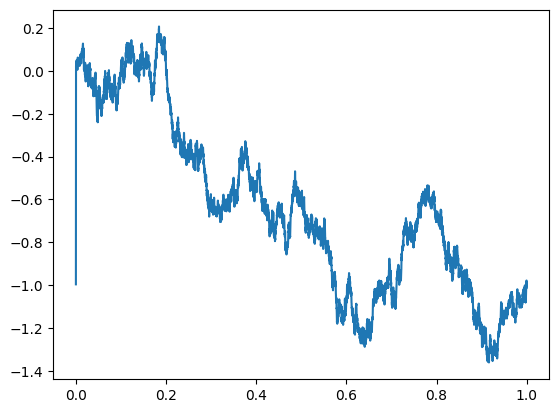

In [4]:
# Plot the process
x = np.linspace(0,1,10000)
y = np.vectorize(process)(x)
plt.plot(x,y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


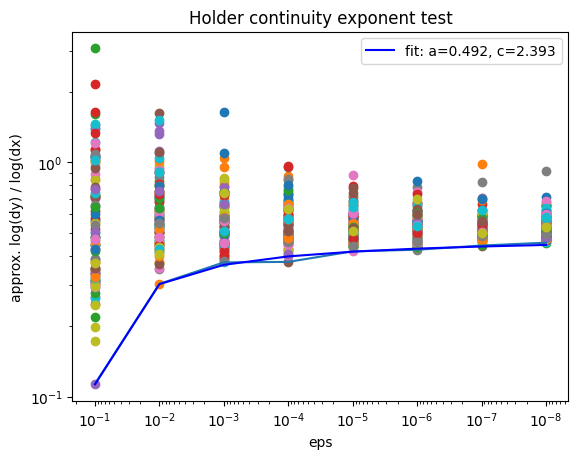

array([0.49175392, 2.39277773])

In [5]:
# Test 2: Hölder continuity exponent

# alpha = 0.2
def plot_and_fit():
    n = 100
    eps = np.array([
        1e-1, 1e-2, 1e-3, 1e-4, 
        1e-5, 1e-6, 1e-7, 1e-8, 
    # 1e-9, 1e-10,# 1e-11, 1e-12, 
    # 1e-13, 1e-14, 1e-15, 1e-16, 
    # 1e-17, 1e-18, 1e-19, 1e-20
    ])
    m = len(eps)
    x = np.random.rand(n) * 0.8 + 0.1
    dx = eps
    x1 = np.tile(x, (m,1)) - np.tile(dx/2, (n,1)).T
    x2 = np.tile(x, (m,1)) + np.tile(dx/2, (n,1)).T
    y1 = np.vectorize(process)(x1)
    y2 = np.vectorize(process)(x2)
    dy = y2 - y1
    a = np.log(np.abs(dy)) / np.tile(np.log(np.abs(dx)), (n,1)).T
    plt.plot(eps, a, 'o', 
    ) # should not converge
    #log scale
    plt.xscale('log')
    plt.yscale('log')
    # invert x axis
    plt.gca().invert_xaxis()
    # draw horizontal line at y=0.5
    # plt.axhline(y=alpha, color='r', linestyle='-', label = f'Theoretical value = {alpha}')

    plt.title('Holder continuity exponent test')
    plt.xlabel('eps')
    plt.ylabel('approx. log(dy) / log(dx)')
    plt.legend()

    # curve fitting
    inf_a = np.min(a, axis=1)
    # fit a curve
    from scipy.optimize import curve_fit
    def func(eps, a, c):
        return a + np.log(c) / (np.log(eps))
    xdata = eps
    ydata = inf_a
    popt, pcov = curve_fit(func, xdata, ydata)
    plt.plot(xdata, ydata)
    plt.plot(xdata, func(xdata, *popt), 'b-',
    label='fit: a=%5.3f, c=%5.3f' % tuple(popt))
    plt.xscale('log')
    plt.yscale('log')
    # invert x axis
    # plt.gca().invert_xaxis()
    # draw horizontal line at y=0.5

    plt.legend()
    plt.show()
    return popt

plot_and_fit()

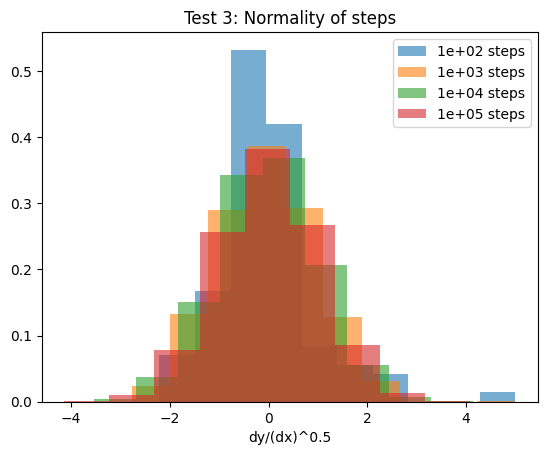

Text(0.5, 1.0, 'p-value for normal test')

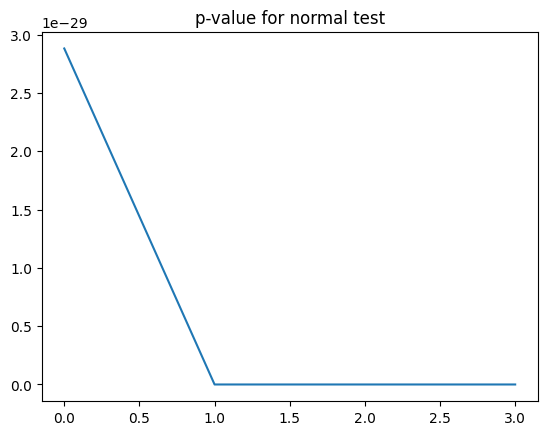

In [6]:
# Test 3: Normality of steps
# We split the interval [0,1] into n intervals. We then test 
# the normality of the steps.
# To pass the test, the steps should be normally distributed,
# with mean 0 and variance 1/n.
# Graphically, the shape of the histogram should stabalize to 
# a standard bell curve.

ps = []
for n in [1e2,1e3,1e4, 1e5]:
    x = np.linspace(0,1,int(n))
    y = np.vectorize(process)(x)
    diff = y[1:] - y[:-1]
    res = diff*(n**0.5)
    np.clip(res, -5, 5, out=res)
    *_, p = scipy.stats.normaltest(diff)
    ps.append(p)
    plt.hist(res, alpha = 0.6, 
        density = True,
        label = f'{n:.0e} steps')

plt.legend()
plt.title('Test 3: Normality of steps')
plt.xlabel('dy/(dx)^0.5')

plt.show()
plt.plot(ps)
plt.title('p-value for normal test')

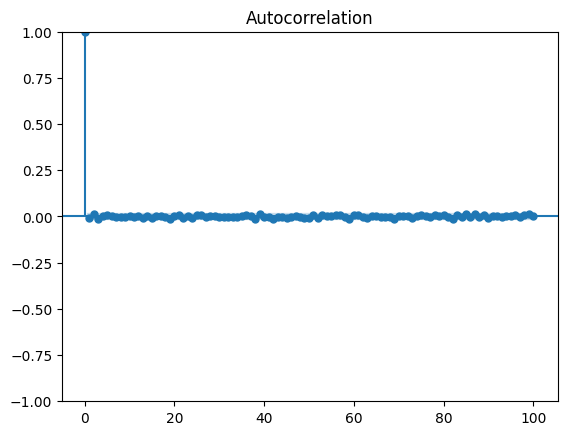

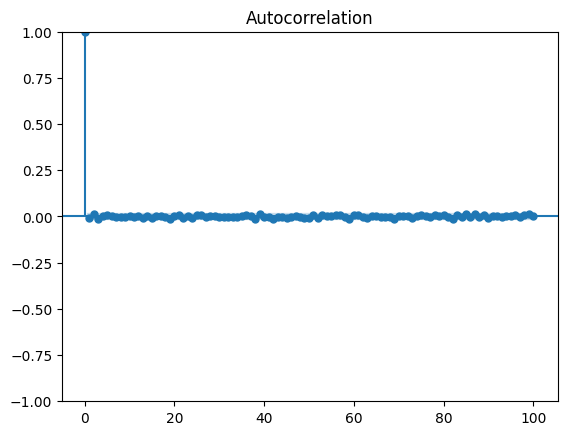

In [7]:
# Test 4: Memorylessness
# We split the interval [0,1] into n intervals. We then test
# the memorylessness of the discrete process (x1,x2,x3,...,xn)
# by testing the independence of (x1,x2) and (x2,x3).
# To pass the test, the first-order difference should be white noise.

plot_acf(
    np.diff(
    np.vectorize(process)(np.linspace(0,1,10000))
    ), lags = 100)

K-S test result: 0.2513254047857859


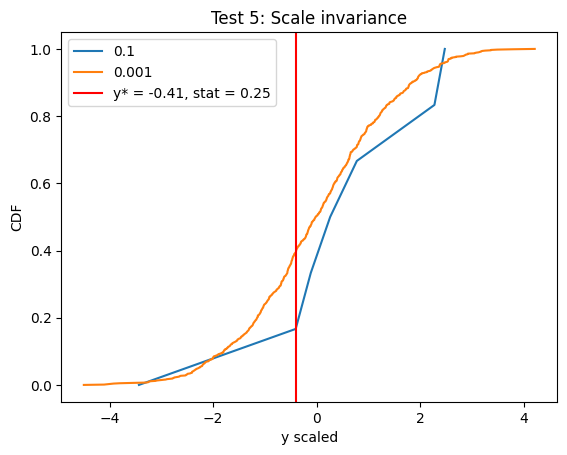

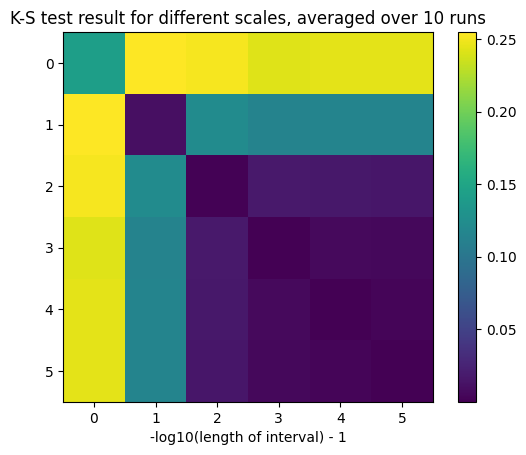

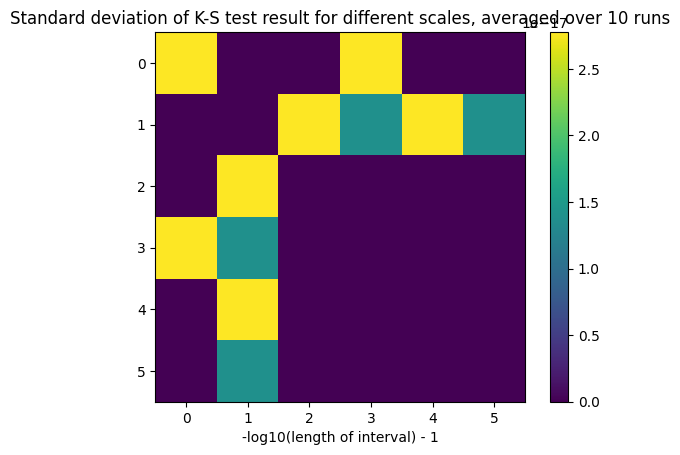

In [8]:
# Test 5: Scale invariance
# We pick a subinterval and stretch it to the whole interval.
# All test results above should be stable and make no significant change.
# K-S test is used to compare the distribution functions.

# empirical k-s test
def ks_test(x, y):
    x = np.sort(x)
    y = np.sort(y)
    n = len(x)
    m = len(y)
    i = 0
    j = 0
    d = 0


    while i < n and j < m:
        if x[i] < y[j]:
            if d < np.abs((i+1)/n - j/m):
                d = np.abs((i+1)/n - j/m)
                v = y[j]
            i += 1
        else:
            if d < np.abs(i/n - (j+1)/m):
                d = np.abs(i/n - (j+1)/m)
                v = x[i]
            j += 1
    return d, v

def run_scaled_ks_test(length1 ,length2, plot=True):
    # perform k-s test on the whole process and half of it
    # the result should be the same
    x1 = np.linspace(0,1,int(1/length1))
    y1 = np.vectorize(process)(x1)
    y1 = np.diff(y1)
    x2 = np.linspace(0,1,int(1/length2))
    y2 = np.vectorize(process)(x2)
    y2 = np.diff(y2)
    
    y1 = np.diff(y1)[1:] / (length1)**0.5
    y2 = np.diff(y2)[1:] / (length2)**0.5

    res, v = ks_test(y1,y2)
    if plot:
        # print the result of k-s test on the whole process and half of it
        print(f'K-S test result: {res}')
        # plot the distribution function of the whole process and half of it
        plt.plot(np.sort(y1), np.linspace(0,1,len(y1)), label = repr(length1))
        plt.plot(np.sort(y2), np.linspace(0,1,len(y2)), label = repr(length2))
        # vertical line segment at v
        plt.axvline(x=v, color='r', linestyle='-', label = f'y* = {v:.2}, stat = {res:.2}')
        plt.title('Test 5: Scale invariance')
        plt.xlabel('y scaled')
        plt.ylabel('CDF')
        plt.legend()
        plt.show()
    return res, v

run_scaled_ks_test(0.1, 0.001)

# heatmap for different scales

def heatmap():
    n_scales = 6
    repeat = 10
    res = np.zeros((n_scales, n_scales))
    res_std = np.zeros((n_scales, n_scales))
    for i in range(n_scales):
        for j in range(n_scales):
            ds = []
            for _ in range(repeat):
                # randomly generate x1, x2
                d = run_scaled_ks_test(
                    10**(-i-1), 
                    10**(-j-1), plot=False)[0]
                ds.append(d)
            res[i,j] = np.mean(ds)
            res_std[i,j] = np.std(ds)
    plt.imshow(res)
    plt.colorbar()
    plt.xlabel('-log10(length of interval) - 1')
    plt.title(f'K-S test result for different scales, averaged over {repeat} runs')
    plt.show()
    plt.imshow(res_std)
    plt.colorbar()
    plt.xlabel('-log10(length of interval) - 1')
    plt.title(f'Standard deviation of K-S test result for different scales, averaged over {repeat} runs')
    plt.show()
heatmap()